In [135]:
    
from mesa.space import MultiGrid
from mesa import Model
from mesa.time import RandomActivation
import numpy as np
from queue import Queue


class ElFarolBar(Model):
    def __init__(self, crowdthreshold=60,num_strategies=10,memory_size = 10,width = 100,height = 100,N=100):
        self.running = True 
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.history = np.random.randint(0,100,size = memory_size*2).tolist()
        self.attendance = self.history[0]
        for i in range(self.num_agents):
            a = BarCustomer(i,self, num_strategies,memory_size,crowdthreshold) 
            self.schedule.add(a)
        self.datacollector = DataCollector(
            model_reporters ={'Customers':"attendance"},
            agent_reporters={"Utility": "utility"})
    def step(self):
        self.datacollector.collect(self)
        self.attendance = 0
        self.schedule.step()
        self.history.pop(0)
        self.history.append(self.attendance)
        for agent in self.schedule.agent_buffer(shuffled=False):
            agent.update_strategies()
        


In [154]:
from mesa import Agent
from mesa.datacollection import DataCollector

class BarCustomer(Agent):
    def __init__(self, unique_id, model,num_strategies,memory_size,crowdthreshold):
        super().__init__(unique_id, model)
        self.strategies = 1- np.random.rand(num_strategies,memory_size+1)*1.8
        self.best_strategy = self.strategies[0]
        self.attend = False
        self.memory_size = memory_size
        self.crowdthreshold = crowdthreshold
        self.utility = 0 
        self.update_strategies()

    #need to add step method here, to activate make_decision
    def step(self):
        prediction = self.predict_attendance(self.best_strategy,self.model.history[-self.memory_size:])
        if prediction<=self.crowdthreshold:
            self.attend = True
            self.model.attendance = self.model.attendance +1
        else: 
            self.attend = False
    
    def update_strategies(self):
        best_score = float('inf')
        for strategy in self.strategies:
            score, week = 0,0
            for _ in range(self.memory_size):
                prediction = self.predict_attendance(strategy,\
                                                     self.model.history[week:week+self.memory_size])
                socre = score + abs(self.model.history[week+self.memory_size]-prediction)
                week = week + 1
            if score <= best_score:
                best_score = score
                self.best_strategy = strategy
        if (self.model.history[-1]>self.crowdthreshold and self.attend ==True) or (self.model.history[-1]<self.crowdthreshold and self.attend ==False):
            self.utility = self.utility -1 
        else:
            self.utility = self.utility +1 
    
    def predict_attendance(self,strategy,subhistory):
        #print(strategy[1:],subhistory,strategy[0],strategy[0]*100+ sum(strategy[1:]*subhistory))
        return strategy[0]*100+ sum(strategy[1:]*subhistory)

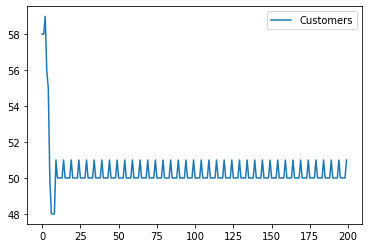

In [155]:
model = ElFarolBar(N=100,crowdthreshold=50,memory_size=5)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

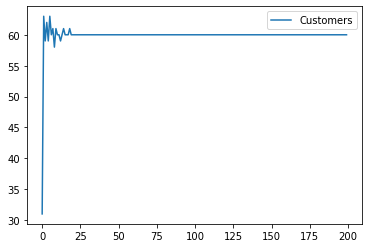

In [130]:
model = ElFarolBar(N=100,crowdthreshold=60,memory_size=10)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

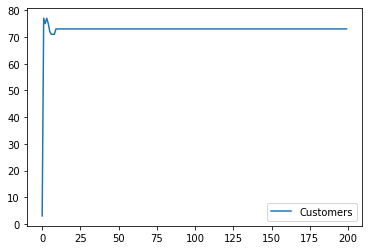

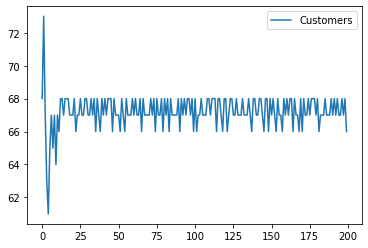

In [60]:
model = ElFarolBar(N=100,crowdthreshold=70,memory_size=5)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

model = ElFarolBar(N=100,crowdthreshold=70,memory_size=10)#,num_strategies=20)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

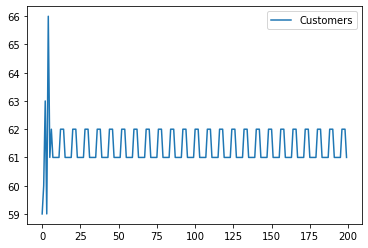

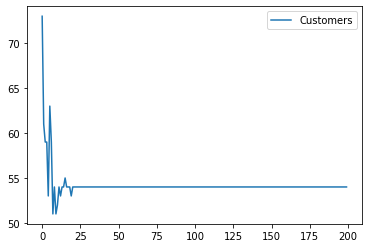

In [156]:
import matplotlib.pyplot as plt
m = [5,10]
trials = 200
models = [ElFarolBar(N=100,crowdthreshold=70,memory_size=memory_size) for memory_size in m]
for model in models:
    for i in range(trials):
        model.step()
    gini = model.datacollector.get_model_vars_dataframe()
    gini.plot()
    

In [157]:
df = models[0].datacollector.get_agent_vars_dataframe()
df

Utility
Step AgentID         
0    0              1
     1              1
     2              1
     3              1
     4              1
...               ...
199  95           200
     96           200
     97          -190
     98          -194
     99           198

[20000 rows x 1 columns]

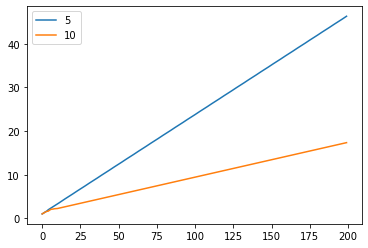

In [161]:
for idx in range(len(m)):
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    plt.plot(df['Utility'].groupby('Step').mean(),label = str(m[idx]))
plt.legend()

In [90]:
class ElFarolBarIBLT(Model):
    def __init__(self, crowdthreshold=60,decay=1,memory_size = 10,width = 100,height = 100,N=100):
        self.running = True 
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.history = np.random.randint(0,100,size = memory_size*2).tolist()
        self.attendance = self.history[0]
        for i in range(self.num_agents):
            a = BarCustomerIBLT(i,self,decay,crowdthreshold) 
            self.schedule.add(a)
        self.datacollector = DataCollector(
            model_reporters ={'Customers':"attendance"},
            agent_reporters={"Utility": "utility"})
    def step(self):
        self.datacollector.collect(self)
        self.attendance = 0
        self.schedule.step()
        self.history.pop(0)
        self.history.append(self.attendance)
        for agent in self.schedule.agent_buffer(shuffled=False):
            agent.update_strategies()

In [169]:
##Cognitive based model IBLT 
import pyibl 
import random
class BarCustomerIBLT(Agent):
    def __init__(self, unique_id, model,decay,crowdthreshold):
        super().__init__(unique_id, model)
        self.agent = pyibl.Agent("BarCustomer",["Attendence"],decay = decay,noise = random.uniform(0.1,1.5))
        self.agent.default_utility=10
        self.attend = False
        self.utility = 10
        self.crowdthreshold = crowdthreshold
        self.step()
        self.update_strategies()
        

    #need to add step method here, to activate make_decision
    def step(self):
        choise = self.agent.choose('Attend','Not Attend')
        if choise =='Attend':
            self.attend = True
            self.model.attendance = self.model.attendance +1
        else: 
            self.attend = False
    
    def update_strategies(self):
        if (self.model.history[-1]>self.crowdthreshold and self.attend ==True) or (self.model.history[-1]<self.crowdthreshold and self.attend ==False):
            self.agent.respond(-1)
            self.utility = self.utility -1 
        else:
            self.agent.respond(1)
            self.utility = self.utility +1 


In [173]:
n = 50
trials = 400
models = [ElFarolBarIBLT(N=100,crowdthreshold=n,memory_size=5,decay = 0.1),
         ElFarolBarIBLT(N=100,crowdthreshold=n,memory_size=5,decay = 1),
        ElFarolBarIBLT(N=100,crowdthreshold=n,memory_size=5,decay = 2.5),
        ElFarolBarIBLT(N=100,crowdthreshold=n,memory_size=5,decay = 5)]

for model in models:
    for i in range(trials):
        model.step()

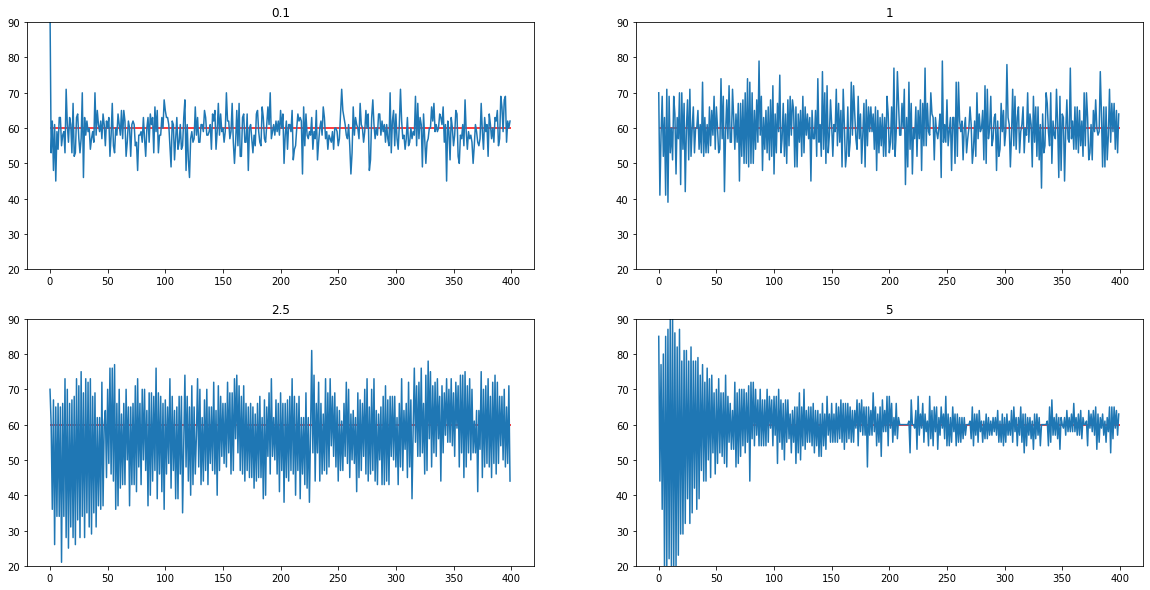

In [180]:
plt.figure(figsize = (20,10))
for idx in range(4):
    plt.subplot(2,2,idx+1)
    model = models[idx]
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df['Customers'],label = str(d[idx]))
    plt.ylim([20,90])
    plt.title(str(d[idx]))
    plt.hlines(n,0,400,'r')


In [ ]:
model = ElFarolBarIBLT(N=100,crowdthreshold=n,memory_size=5,decay = 0.1)
for i in range(trials):
    model.step()

In [149]:
import pyibl 
a = pyibl.Agent("BarCustomer",["Attendence"])
a.default_utility = 10
a.choose('Attend','Not Attend')


'Not Attend'

In [150]:
a.respond(1)

In [151]:
a.choose(['Attend',20],['Not Attend',50])


['Not Attend', 50]

In [152]:
a.respond(-1)

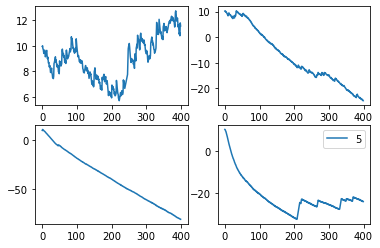

In [183]:
import matplotlib.pyplot as plt
d = [0.1,1,2.5,5]
for idx in range(4):
    plt.subplot(2,2,idx+1)
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    plt.plot(df['Utility'].groupby('Step').mean(),label = str(d[idx]))
plt.legend()